# Panoramic Mosaicing


What we want to do is construct a panorama given photographs. We assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera). 

To start off, we'll find interest points and descriptors of each image

In [1]:
import numpy as np
from skimage.transform import resize
import cv2 as cv
from matplotlib import pyplot as plt
from itertools import combinations
from itertools import permutations
from IPython.display import Image


### Find Interest Points and Descriptors in each Input Image

The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  

The red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.


In [2]:
def fixImage(imageName):
    img = cv.imread(imageName)
    image_resized = (255*resize(img, (600,600),
                       anti_aliasing=True)).astype('uint8')
    gray= cv.cvtColor(image_resized,cv.COLOR_BGR2GRAY)
    return gray, image_resized

def loadDetectCompute(img,gray):
    """downsamples image and detects and computes the interest points and descriptors"""
    
    sift = cv.xfeatures2d.SIFT_create()
    kp,des = sift.detectAndCompute(gray,None)
    img1=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return kp,des,img1

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


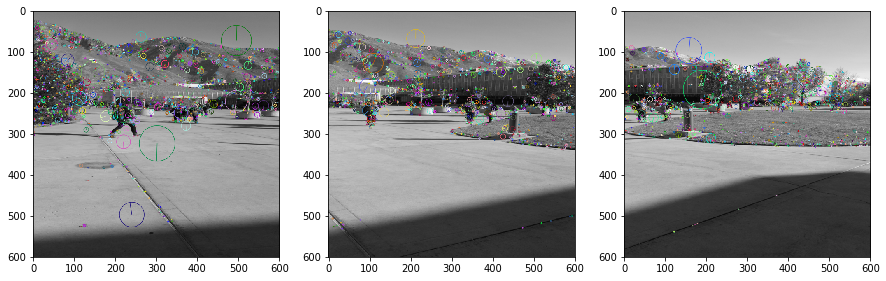

In [3]:
kps, descs,imgs = [],[],[]
fig = plt.figure(figsize=(15,9))
i=1
for x in ['Images/campus1.jpg','Images/campus3.jpg','Images/campus2.jpg']:
    gray,img = fixImage(x)
    imgs.append(gray)
    kp,desc,img1 = loadDetectCompute(img,gray)
    kps.append(kp)
    descs.append(desc)
    plt.subplot(1,3,i)
    plt.imshow(img1)
    i+=1
plt.show()


### Matching Features

Next, given the features present in each image, we will match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation. We only want putative matches.

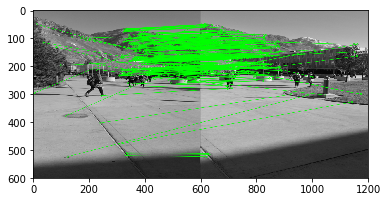

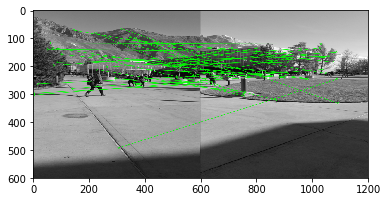

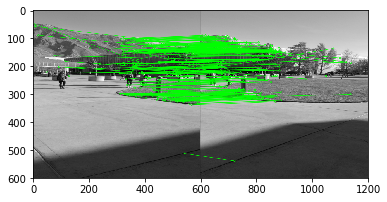

In [18]:

def MatchFeatures(img1,img2,des1,des2,kp1,kp2,show = True):
    # Match descriptors.
    matches1 = []
    matches2 = []
    const = 0.85
    ms1 = cv.BFMatcher().knnMatch(des1,des2,k=2)
    # Apply ratio test from the first image to the second
    for m,n in ms1:
        if m.distance < const*n.distance:
            matches1.append(m)
            
    ms2 = cv.BFMatcher().knnMatch(des2,des1,k=2)
    # Apply ratio test from the second image to the first
    for m,n in ms2:
        if m.distance < const*n.distance:
            matches2.append(m)
                    
    matches = []
    #only get putative matches
    for x in matches1:
        for y in matches2:
            if x.queryIdx == y.trainIdx and y.queryIdx == x.trainIdx:
                matches.append(x)
                break
                
    #draw the result
    draw_params = dict(matchColor = (0,255,0),
                       flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(img1,kp1,img2,kp2,matches, None,**draw_params)
    if show:
        plt.imshow(img3),plt.show()
    return matches

allMatches=[]
for i,j in combinations([l for l in range(len(imgs))],2):
    allMatches.append((i,j,MatchFeatures(imgs[i],imgs[j],descs[i],descs[j],kps[i],kps[j])))

### Estimating Pairwise Homographies using RANSAC

To estimate the homography between each pair of images, we will programmatically determine the base image and use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4).

Below you will find a visualization of the RANSAC estimated homographies.  

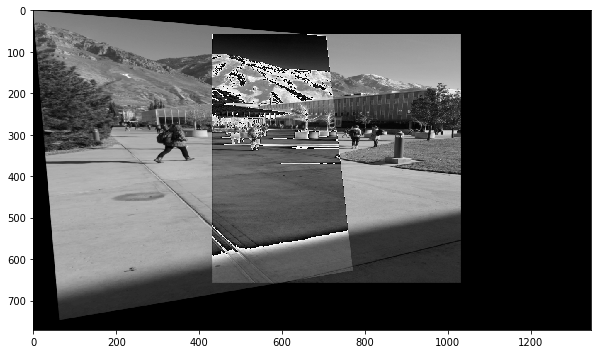

In [13]:
def RANSAC(matches,kp1,kp2):
    source = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dest = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    src = np.copy(source[:,0])
    dst = np.copy(dest[:,0])
    
    iters = 0
    k=1000
    homographies=[]
    accumulator = []
    thresh = 5
    
    while iters < k:
        seed = np.random.randint(0,src.shape[0],4)
        pp0,pp1,pp2,pp3 = [dst[k] for k in seed]
        p0,p1,p2,p3 = [src[k] for k in seed]
        A = np.array([[p0[0],p0[1],1,0,0,0,-p0[0]*pp0[0],-pp0[0]*p0[1]],
                     [0,0,0,p0[0],p0[1],1,-pp0[1]*p0[0],-pp0[1]*p0[1]],
                     [p1[0],p1[1],1,0,0,0,-p1[0]*pp1[0],-pp1[0]*p1[1]],
                     [0,0,0,p1[0],p1[1],1,-pp1[1]*p1[0],-pp1[1]*p1[1]],
                      [p2[0],p2[1],1,0,0,0,-p2[0]*pp2[0],-pp2[0]*p2[1]],
                     [0,0,0,p2[0],p2[1],1,-pp2[1]*p2[0],-pp2[1]*p2[1]],
                      [p3[0],p3[1],1,0,0,0,-p3[0]*pp3[0],-pp3[0]*p3[1]],
                     [0,0,0,p3[0],p3[1],1,-pp3[1]*p3[0],-pp3[1]*p3[1]]])
        
        b = np.array([pp0[0],pp0[1],pp1[0],pp1[1],pp2[0],pp2[1],pp3[0],pp3[1]])
        try:
            homography = np.hstack((np.linalg.solve(A,b),np.array(1)))
            homography = np.reshape(homography,(3,3))
            homographies.append(homography)
            accumulator.append(0)
            for i in range(len(matches)):
                pp = kp2[matches[i].trainIdx].pt
                p = kp1[matches[i].queryIdx].pt
                b1 = np.array([p[0],p[1],1])
                newpt = homography@b1
                error = np.linalg.norm(newpt/newpt[2] - np.array([pp[0],pp[1],1]))
                if error < thresh:
                    accumulator[-1] += 1
        except:
            continue
        finally:
            iters+=1
    best = homographies[np.argmax(accumulator)]
    return best

def warpImage(img,ph):
    # Find the corners after the transform has been applied
    height, width = img.shape[:2]
    corners = np.array([
      [0, 0],
      [0, height - 1],
      [width - 1, height - 1],
      [width - 1, 0]
    ])
    corners = cv.perspectiveTransform(np.float32([corners]), ph)
    # Find the bounding rectangle
    bx, by, bwidth, bheight = cv.boundingRect(corners)
#     print(bx,by)

    # Compute the translation homography that will move (bx, by) to (0, 0)
    th = np.array([
      [ 1, 0, -bx ],
      [ 0, 1, -by ],
      [ 0, 0,   1 ]
    ])

    # Combine the homographies
    pth = th@ph
    # Apply the transformation to the image
    return cv.warpPerspective(img, pth, (bheight + baseimg.shape[0], bwidth)),th,bheight,bwidth

def stitch2(i,j,show=False):
    matches = MatchFeatures(imgs[i],imgs[j],descs[i],descs[j],kps[i],kps[j],False)
    ph = RANSAC(matches,kps[i],kps[j])

    warp1,th,bh,bw = warpImage(imgs[i],ph)
    base1 = cv.warpPerspective(imgs[j], np.float32(th), (bh + baseimg.shape[0],bw))
    res = warp1+base1
    if show:
        fig = plt.figure(figsize=(10,10))
        plt.imshow(res,'gray')
        plt.show()
    return res
#Choose the base image as the image with the most hits
def determineBase(allMatches):
    d = dict()
    for i,j,mat in allMatches:
#         print(len(mat))
        if len(mat) > 40:
            if i not in d:
                d[i] = 1
            else:
                d[i]+=1
            if j not in d:
                d[j] = 1
            else:
                d[j]+=1
    mats = []
    for x in d:
        mats.append((x,d[x]))
#     print(d)
    mats = [i[0] for i in sorted(mats,key=lambda x:x[1])[::-1]]
#     print(mats)
    orderedMatches = [allMatches[i] for i in mats[1:]]
    # print([i[:2] for i in orderedMatches])
    base = imgs[mats[0]]
    #The rest will be attatched according to how many matches they have
    return base,mats[0]

baseimg,idx = determineBase(allMatches)
trash=stitch2(0,idx,True)

### Creating the Mosaic

Begin with the base image we will warp the remaining images (using the estimated homographies) to composite them onto the base image.

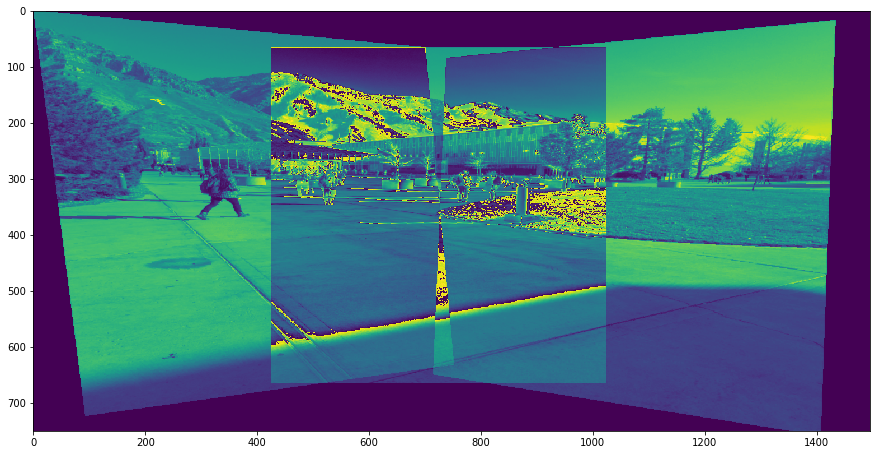

In [14]:
def calcx(ph,xsrc,ysrc):
    return (ph[0][0] * xsrc + ph[0][1]*ysrc+ph[0][2])/(ph[2][0]*xsrc+ph[2][1]*ysrc+1)
def calcy(ph,xsrc,ysrc):
    return (ph[1][0] * xsrc + ph[1][1]*ysrc+ph[1][2])/(ph[2][0]*xsrc+ph[2][1]*ysrc+1)

def stitch3(idxs,imgs,show=False):
    j,i,k = idxs
    matches1 = MatchFeatures(imgs[i],imgs[j],descs[i],descs[j],kps[i],kps[j],show)
    ph1 = RANSAC(matches1,kps[i],kps[j])
    
    h1,w1 = imgs[i].shape[:2]
    corners1 = [[calcx(ph1,0,0),calcy(ph1,0,0)],
                 [calcx(ph1,0,h1-1),calcy(ph1,0,h1-1)],
                 [calcx(ph1,w1-1,h1-1),calcy(ph1,w1-1,h1-1)],
                 [calcx(ph1,w1-1,0),calcy(ph1,w1-1,0)]]
    
    
    matches2 = MatchFeatures(imgs[k],imgs[j],descs[k],descs[j],kps[k],kps[j],show)
    ph2 = RANSAC(matches2,kps[k],kps[j])
    h1,w1 = imgs[k].shape[:2]

    corners2 = [[calcx(ph2,0,0),calcy(ph2,0,0)],
                 [calcx(ph2,0,h1-1),calcy(ph2,0,h1-1)],
                 [calcx(ph2,w1-1,h1-1),calcy(ph2,w1-1,h1-1)],
                 [calcx(ph2,w1-1,0),calcy(ph2,w1-1,0)]]
    corners = np.float32([[min(corners1[i][0],corners2[i][0]),min(corners1[i][1],corners2[i][1])] for i in range(4)])
    
    
    bx, by, bwidth, bheight = cv.boundingRect(corners)
#     print(bx,by)

    # Compute the translation homography that will move (bx, by) to (0, 0)
    th = np.float32([
      [ 1, 0, -bx ],
      [ 0, 1, -by ],
      [ 0, 0,   1 ]
    ])

    # Combine the homographies
    pth1 = th@ph1
    pth2 = th@ph2    
    # Apply the transformation to the image
    width = int(max(corners,key=lambda x:x[0])[0]-min(corners,key=lambda x:x[0])[0])
    height = 2*int(abs(max(corners,key=lambda x:x[1])[1])+abs(min(corners,key=lambda x:x[1])[1]))+200

    warp1 = cv.warpPerspective(imgs[i], pth1, (height,width),flags=cv.INTER_NEAREST)
    warp2 = cv.warpPerspective(imgs[k], pth2, (height,width),flags=cv.INTER_NEAREST)
    base = cv.warpPerspective(imgs[j], th, (height,width),flags=cv.INTER_NEAREST)
    
    fig = plt.figure(figsize=(15,15))
    res = warp1+base+warp2
    plt.imshow(res)
    plt.show()
    return


baseimg,idx = determineBase(allMatches)
indexes = [idx] + [i for i in range(len(imgs)) if i != idx]
stitch3(indexes,imgs)

### Final Results and Improvements

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


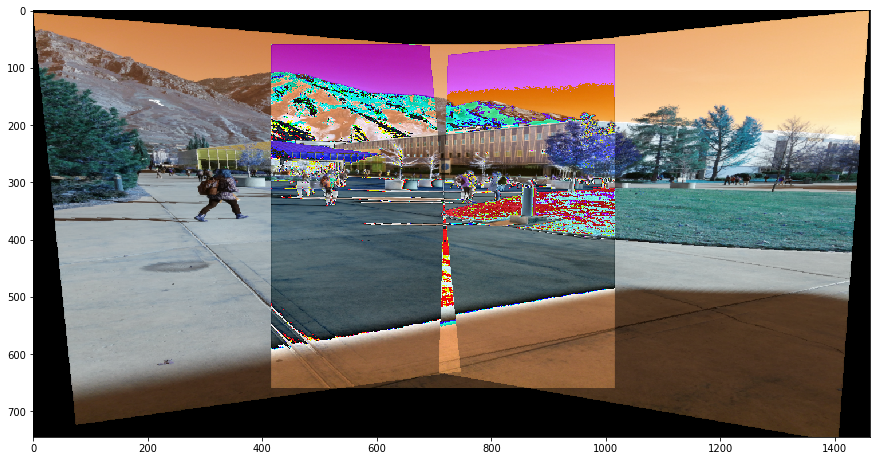

In [12]:
colorimgs = []
for x in ['Images/campus1.jpg','Images/campus3.jpg','Images/campus2.jpg']:
    img = cv.imread(x,cv.IMREAD_COLOR)
    image_resized = (255*resize(img, (600,600),
                       anti_aliasing=True)).astype('uint8')
    colorimgs.append(image_resized)

baseimg,idx = determineBase(allMatches)
indexes = [idx] + [i for i in range(len(imgs)) if i != idx]
stitch3(indexes,colorimgs)

Here's one I took with my very own camera

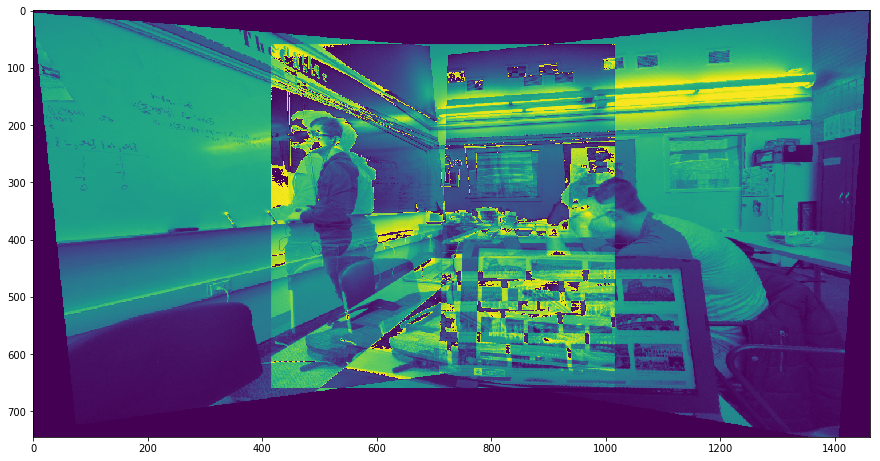

In [13]:
colorimgs = []
for x in ['Images/Castle1.jpg','Images/Castle3.jpg','Images/Castle2.jpg']:
    img = cv.imread(x)
    image_resized = (255*resize(img, (600,600),
                       anti_aliasing=True)).astype('uint8')
    gray= cv.cvtColor(image_resized,cv.COLOR_BGR2GRAY)
    colorimgs.append(gray)

baseimg,idx = determineBase(allMatches)
indexes = [idx] + [i for i in range(len(imgs)) if i != idx]
stitch3(indexes,colorimgs)

It's important to note that it's always hard to get good alignments. It'd be even harder to get a good alignment if there was very little overlap between images and if they were scaled and angled very differently.

What we're missing in this implementation of panoramic mosaicing is a composite blending feature that would get rid of the odd overlap we see